In [ ]:
#@title
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The Transformer architecture was presented in ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) and introduced a new architecture for many NLP tasks.

In this post we present an explanation of the Transformer architecture focusing on the fairseq implementation. We believe this could be useful for researchers and developers working on this framework.


# Prelims

Table of Contents


* Table of Contents                               
{:toc}      

# Background

The Transformer was introduced as an alternative model to RNNs and ConvNets that compute representations of its inputs in a constant number of operations. This is made thanks to the self-attention module, which is a kind of attention mechanism that relies on the input sequence of a single data sample to make representations of it.


# Model Architecture

The Transformer is based on a stack of encoders and another stack of decoders. The encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{encoder\_out} = (encoder\_out_1, ..., encoder\_out_n)$. Given $\mathbf{encoder\_out}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive [(cite)](https://arxiv.org/abs/1308.0850), consuming the previously generated symbols as additional input when generating the next.

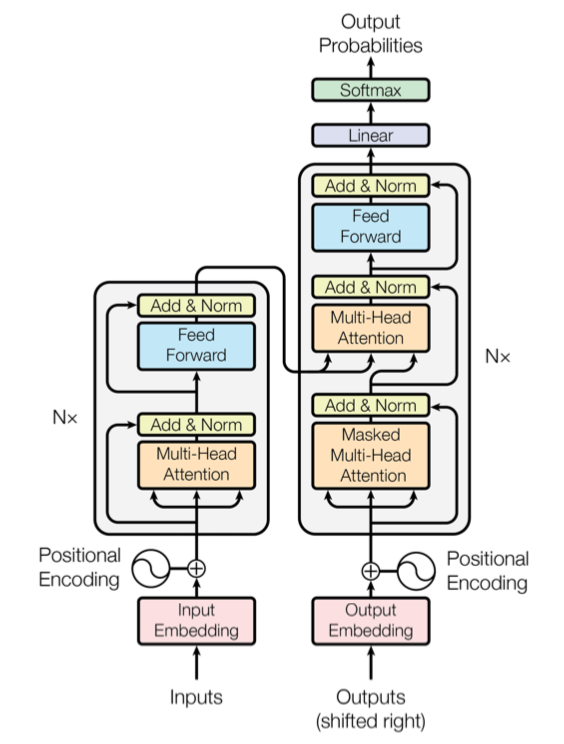

In [ ]:
from IPython.display import Image
path_to_drive = '/content/drive/My Drive/PhD/Colabs/'
Image(filename=path_to_drive + 'images/transformer.png', width = 350, height = 500)

This model is implemented in fairseq in [fairseq/models/transformer.py](https://github.com/pytorch/fairseq/blob/master/fairseq/models/transformer.py)

In [ ]:
class TransformerModel(FairseqEncoderDecoderModel):
  .
  .
  .

def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
        features_only: bool = False,
        alignment_layer: Optional[int] = None,
        alignment_heads: Optional[int] = None,
    ):
        """
        Run the forward pass for an encoder-decoder model.

        Copied from the base class, but without ``**kwargs``,
        which are not supported by TorchScript.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        decoder_out = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            features_only=features_only,
            alignment_layer=alignment_layer,
            alignment_heads=alignment_heads,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return decoder_out

## Encoder and Decoder Stacks

## Encoder

The encoder (<code class="language-plaintext highlighter-rouge">class TransformerEncoder(FairseqEncoder)</code>) is composed of a stack of $N=encoder\_layers$ identical layers. The bottom encoder layer recieves:

<code class="language-plaintext highlighter-rouge">encoder_embedding</code>: the (scaled) embedding lookup of shape (batch, src_len, embed_dim).

<code class="language-plaintext highlighter-rouge">x</code>: <code class="language-plaintext highlighter-rouge">encoder_embedding</code> plus a positional embedding for each of the tokens.

The next encoder layers receive the previous encoder layer output.

In [ ]:
class TransformerEncoder(FairseqEncoder):
  .
  .
  .
  def forward(
        self,
        src_tokens,
        src_lengths,
        return_all_hiddens: bool = False,
        token_embeddings: Optional[torch.Tensor] = None,
    ):

        x, encoder_embedding = self.forward_embedding(src_tokens, token_embeddings)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)

        # compute padding mask
        encoder_padding_mask = src_tokens.eq(self.padding_idx)

        encoder_states = [] if return_all_hiddens else None

        # encoder layers
        for layer in self.layers:
            x = layer(x, encoder_padding_mask)
            if return_all_hiddens:
                assert encoder_states is not None
                encoder_states.append(x)

        if self.layer_norm is not None:
            x = self.layer_norm(x)

        return EncoderOut(
            encoder_out=x,  # T x B x C
            encoder_padding_mask=encoder_padding_mask,  # B x T
            encoder_embedding=encoder_embedding,  # B x T x C
            encoder_states=encoder_states,  # List[T x B x C]
            src_tokens=None,
            src_lengths=None,
        )

### Encoder Layer

The previous snipped of code does a loop over the layers of the Encoder block <code class="language-plaintext highlighter-rouge">for layer in self.layers</code>. This layer is implemented in fairseq in <code class="language-plaintext highlighter-rouge">class TransformerEncoderLayer(nn.Module)</code> inside [fairseq/modules/transformer_layer.py](https://github.com/pytorch/fairseq/blob/master/fairseq/modules/transformer_layer.py) and computes the following operations:

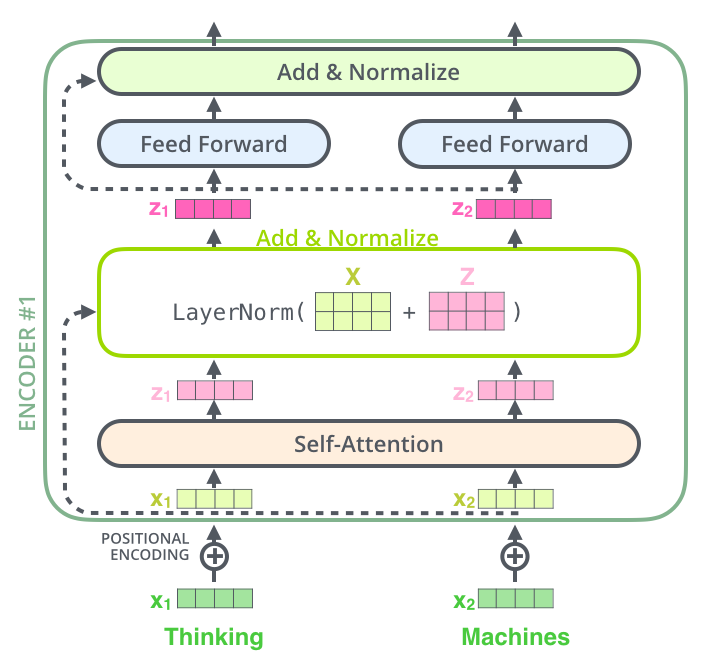

In [ ]:
Image(filename=path_to_drive + 'images/encoder_layer_transformer_full.png', width = 400, height = 350)

The input of the encoder layer <code class="language-plaintext highlighter-rouge">x</code> is passed through the self-attention module <code class="language-plaintext highlighter-rouge">self.self_attn</code>, dropout (<code class="language-plaintext highlighter-rouge">self.dropout_module(x)</code>) is then applied before arriving to the Add & Normalize module (made of a residual connection <code class="language-plaintext highlighter-rouge">self.residual_connection(x, residual)</code> and a layer normalization <code class="language-plaintext highlighter-rouge">self.self_attn_layer_norm(x)</code>

In [ ]:
class TransformerEncoderLayer(nn.Module):
  .
  .
  .
  def forward(self, x, encoder_padding_mask, attn_mask: Optional[Tensor] = None):
    if attn_mask is not None:
            attn_mask = attn_mask.masked_fill(attn_mask.to(torch.bool), -1e8)

        residual = x
        if self.normalize_before:
            x = self.self_attn_layer_norm(x)
        x, _ = self.self_attn(
            query=x,
            key=x,
            value=x,
            key_padding_mask=encoder_padding_mask,
            attn_mask=attn_mask,
        )
        x = self.dropout_module(x)
        x = self.residual_connection(x, residual)
        if not self.normalize_before:
            x = self.self_attn_layer_norm(x)

Then, the result is passed through a position-wise feed-forward network composed by two fully connected layers, <code class="language-plaintext highlighter-rouge">fc1</code> and <code class="language-plaintext highlighter-rouge">fc2</code> with a ReLU activation in between (<code class="language-plaintext highlighter-rouge">self.activation_fn(self.fc1(x))</code>) and dropout <code class="language-plaintext highlighter-rouge">self.dropout_module(x)</code>.



In [ ]:
        residual = x
        if self.normalize_before:
            x = self.final_layer_norm(x)

        x = self.activation_fn(self.fc1(x))
        x = self.activation_dropout_module(x)
        x = self.fc2(x)
        x = self.dropout_module(x)
       

Finally, a residual connection is made before another layer normalization layer.

In [ ]:
        x = self.residual_connection(x, residual)
        if not self.normalize_before:
            x = self.final_layer_norm(x)
        return x

#### Self-attention

The input of each encoder layer is firstly passed through a self-attention layer ([fairseq/modules/multihead_attention.py](https://github.com/pytorch/fairseq/blob/master/fairseq/modules/multihead_attention.py))

In [ ]:
class MultiheadAttention(nn.Module):
  .
  .
  def forward(
        self,
        query,
        key: Optional[Tensor],
        value: Optional[Tensor],
        key_padding_mask: Optional[Tensor] = None,
        incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]] = None,
        need_weights: bool = True,
        static_kv: bool = False,
        attn_mask: Optional[Tensor] = None,
        before_softmax: bool = False,
        need_head_weights: bool = False,
    ) -> Tuple[Tensor, Optional[Tensor]]:

Each matrix Query (Q), a Key (K), and a Value (V) are created by multiplying the encoder's input by three weight matrices, $W^{Q}, W^{K}$ and $W^{V}$. These $Q$, $K$ and $V$ are matrices in which each row represents the $q$, $k$ and $v$ vector of each token in the sequence.

In [ ]:
if self.self_attention:
            q = self.q_proj(query)
            k = self.k_proj(query)
            v = self.v_proj(query)
q *= self.scaling

The self-attention module does the following operation:

$$
\mathrm{Attention}(Q,K,V) = \mathrm{softmax}(\frac{QK^{T}}{d_{k}})V
$$

In [ ]:
attn_weights = torch.bmm(q, k.transpose(1, 2))
assert list(attn_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

A score between the input token of the sequence and every other is calculated. This score represents how much focus to put on other parts of the sequence when encoding a specific token (i in this case). So, a dot product is calculated between the $q_{i}$ vector and the Key vector of every other object in the sequence (the intuition is that this is a similarity operation, we try to find the key similar to the queries and give a high value to them), which is equivalent to multiplying $q_{i}$ by the matrix $K^{T}$, giving as many scores as elements in the sequence.

Then this output of scalars are divided by the square root of the dimension of the key vectors $d_{k}$ (for getting more stable gradients), done previously <code class="language-plaintext highlighter-rouge">q *= self.scaling</code>, and finally it is passed through a softmax operation.

In [ ]:
attn_weights_float = utils.softmax(
            attn_weights, dim=-1, onnx_trace=self.onnx_trace
        )
attn_weights = attn_weights_float.type_as(attn_weights)


Once we have a normalized score for every pair of tokens, we multiply this score by the value vector of each of the tokens (each row in matrix $V$) and finally sum up those vectors, generating $Z$.

In [ ]:
attn_probs = self.dropout_module(attn_weights)
assert v is not None
attn = torch.bmm(attn_probs, v)

This process is done in each of the self-attention heads, in the original transformer the model has 8 heads. So, in total 8 matrices are output. Each head has its own $W^{Q}, W^{K}$ and $W^{V}$ weight matrices which are randomly initialized, so the result leads to different representation subspaces in each of the self-attention heads.

 
 The output matrix $Z$ of every self-attention head are concatenated into a single matrix to which a linear transformation $W^{O}$ (<code class="language-plaintext highlighter-rouge">self.out_proj</code>) is applied, $$MultiHead = Concat(Z_{head_{i}},\cdots,Z_{head_{h}})W^{O}$$

In [ ]:
attn = self.out_proj(attn)
        attn_weights: Optional[Tensor] = None
        if need_weights:
            attn_weights = attn_weights_float.view(
                bsz, self.num_heads, tgt_len, src_len
            ).transpose(1, 0)
            if not need_head_weights:
                # average attention weights over heads
                attn_weights = attn_weights.mean(dim=0)

 return attn, attn_weights

This linear projection is added to the initial embeddings entering the encoder and then a LayerNorm operation is performed.
 
 On top of each encoder and decoder layer the transformer has a feed-forward network (FFN) which consists of two linear transformations with a ReLu activation function after the first transformation.

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

## Decoder

The decoder (<code class="language-plaintext highlighter-rouge">class TransformerDecoder(FairseqDecoder)</code>) is composed of a stack of $N=decoder\_layers$ identical layers


In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer (Encoder-Decoder Attention), which performs multi-head attention over the output of the encoder stack.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  

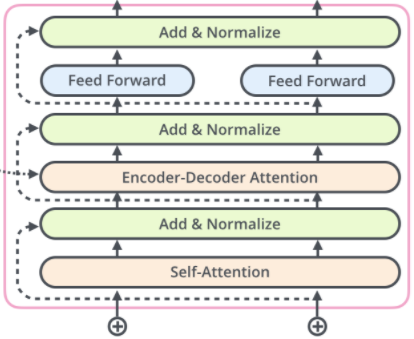

In [ ]:
Image(filename=path_to_drive + 'images/Decoder.png', width = 300, height = 250)

In [ ]:
class TransformerDecoder(FairseqIncrementalDecoder):
  ..
  def forward(
        self,
        prev_output_tokens,
        encoder_out: Optional[EncoderOut] = None,
        incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]] = None,
        features_only: bool = False,
        full_context_alignment: bool = False,
        alignment_layer: Optional[int] = None,
        alignment_heads: Optional[int] = None,
        src_lengths: Optional[Any] = None,
        return_all_hiddens: bool = False,
    ):
        
        x, extra = self.extract_features(
            prev_output_tokens,
            encoder_out=encoder_out,
            incremental_state=incremental_state,
            full_context_alignment=full_context_alignment,
            alignment_layer=alignment_layer,
            alignment_heads=alignment_heads,
        )
        if not features_only:
            x = self.output_layer(x)
        return x, extra

In [ ]:
def extract_features(
        self,
        prev_output_tokens,
        encoder_out: Optional[EncoderOut] = None,
        incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]] = None,
        full_context_alignment: bool = False,
        alignment_layer: Optional[int] = None,
        alignment_heads: Optional[int] = None,
    ):
        return self.extract_features_scriptable(
            prev_output_tokens,
            encoder_out,
            incremental_state,
            full_context_alignment,
            alignment_layer,
            alignment_heads,
        )


In [ ]:
def extract_features_scriptable(
        self,
        prev_output_tokens,
        encoder_out: Optional[EncoderOut] = None,
        incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]] = None,
        full_context_alignment: bool = False,
        alignment_layer: Optional[int] = None,
        alignment_heads: Optional[int] = None,
    ):
  
  ..

# decoder layers
        attn: Optional[Tensor] = None
        inner_states: List[Optional[Tensor]] = [x]
        for idx, layer in enumerate(self.layers):
            if incremental_state is None and not full_context_alignment:
                self_attn_mask = self.buffered_future_mask(x)
            else:
                self_attn_mask = None

            x, layer_attn, _ = layer(
                x,
                encoder_out.encoder_out if encoder_out is not None else None,
                encoder_out.encoder_padding_mask if encoder_out is not None else None,
                incremental_state,
                self_attn_mask=self_attn_mask,
                self_attn_padding_mask=self_attn_padding_mask,
                need_attn=bool((idx == alignment_layer)),
                need_head_weights=bool((idx == alignment_layer)),
            )
            inner_states.append(x)
            if layer_attn is not None and idx == alignment_layer:
                attn = layer_attn.float().to(x)

        if attn is not None:
            if alignment_heads is not None:
                attn = attn[:alignment_heads]

            # average probabilities over heads
            attn = attn.mean(dim=0)

        if self.layer_norm is not None:
            x = self.layer_norm(x)

        # T x B x C -> B x T x C
        x = x.transpose(0, 1)

        if self.project_out_dim is not None:
            x = self.project_out_dim(x)

        return x, {"attn": [attn], "inner_states": inner_states}